# Data Augmentation y Redes PreEntrenadas

## Introducción
Siguiendo con el ejemplo de la clasificación binaria de lo que es Pizza y lo que no, vamos a ver como aplicar dos conceptos que se comentaron en la teoría: **Data Augmentation y Convoluciones PreEntrenadas (Feature Extraction).**

El objetivo del ejercicio es realizar una **Clasificación de Imágenes (Binaria)** en la que podamos decir si una imagen es un plato de comida de **Pizza o No Pizza**.

La base de datos es un conjunto de imágenes de Comida de Pizza y No Pizza.

La base de datos la podréis descargar de esta URL:
https://www.dropbox.com/scl/fi/aegle0xuobcqurc5s1b2i/pizzaNopizza.zip?dl=1

Esta base de datos es una versión reducida de la base de datos de imágenes Food 101 (https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) que recoge 101.000 imágenes de comidas clasificadas en 101 clases diferentes. Para este ejercicio se ha construido una versión con sólo 2 clases, la clase Pizza y la clase No Pizza.

Una vez descargada y descomprimida os encontrareis con una **carpeta pizza_not_pizza**, que tendrá ya las **carpetas test, train**. A su vez cada una de estas contendrá las **carpetas pizza y not_pizza**.

El conjunto de datos se reparte de la siguiente manera:
- **Entrenamiento**. Imágenes Pizza: 885
- **Entrenamiento**. Imágenes Not_Pizza: 885
- **Test**. Imágenes Pizza: 98
- **Test**. Imágenes Not_Pizzas: 98

## Información de versiones e Importación de funciones propias

Presentamos información de las versiones usadas de Python y tensorflow, además definir todas las funciones que luego usamos para no estar escribiendo todo el rato el mismo código.

In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

import tensorflow as tf
print("Tensorflow version")
print(tf.__version__)

Python version
3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:04:44) [MSC v.1940 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=12, micro=4, releaselevel='final', serial=0)
Tensorflow version
2.17.0


In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import applications
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

## Carga del dataset

In [3]:
# Función para descargar el dataset y descomprimirlo
def carga_dataset():
    global train_dir
    global test_dir
    import pathlib
    dataset_url = "https://www.dropbox.com/scl/fi/aegle0xuobcqurc5s1b2i/pizzaNopizza.zip?rlkey=semyw2f1eb41jlkm2z91kdw2l&st=blw8ouuo&dl=1"
    # Descargamos el fichero con todas las imágenes y 
    # lo desempaquetamos
    global data_dir
    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   extract=True)

    data_dir = os.path.dirname(data_dir)

    # Definimos los directorios para usar
    data_dir = data_dir + "\\pizza_not_pizza"
    train_dir = data_dir + "\\train"
    test_dir = data_dir + "\\test"
    print(data_dir)
    print(train_dir)
    print(test_dir)


In [4]:
carga_dataset()

C:\Users\acca3\.keras\datasets\pizza_not_pizza
C:\Users\acca3\.keras\datasets\pizza_not_pizza\train
C:\Users\acca3\.keras\datasets\pizza_not_pizza\test


In [5]:
# Definimos el tamaño del batch
# Definimos el tamaño de imagen con la que queremos trabajar
batch_size = 32
img_height = 100
img_width = 100

## Creación los generadores de imágenes

In [6]:
# Creamos los generadores de imágenes
# Nos van a permitir leer la imágenes desde los directorios
def crea_generadores_imagenes():
    global train_ds
    global val_ds
    global class_names
    global num_classes
    global ficheros_train_pizza
    global ficheros_train_not_pizza
    global ficheros_test_pizza
    global ficheros_test_not_pizza
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      labels = "inferred",  
      seed=123,
      #shuffle=False,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    # Definimos 
    val_ds = tf.keras.utils.image_dataset_from_directory(
      test_dir,
      labels = "inferred", 
      seed=123,
      shuffle=False, # !!!!!! Muy importante dejarlo a false para que no barajee cada vez los de test
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    class_names = train_ds.class_names

    # Directorios de entrenamiento
    ficheros_train_pizza = os.listdir(train_dir+"\\pizza") 
    ficheros_train_not_pizza = os.listdir(train_dir+"\\not_pizza") 
    ficheros_test_pizza = os.listdir(test_dir+"\\pizza") 
    ficheros_test_not_pizza = os.listdir(test_dir+"\\not_pizza")  
    num_classes = 2


In [7]:
crea_generadores_imagenes()

Found 1770 files belonging to 2 classes.
Found 196 files belonging to 2 classes.


## Visualización de imágenes aleatorias

In [8]:
# Función para visualizar imágenes aleatorias (5 de cada clase) de entrenamiento
def visualiza_imagenes_random():

    plt.figure(figsize=(10, 10))
    
    for images, labels in train_ds.map(lambda x, y:  (x[y==0], y[y==0])):
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.map(lambda x, y:  (x[y==1], y[y==1])):
      for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
          
 



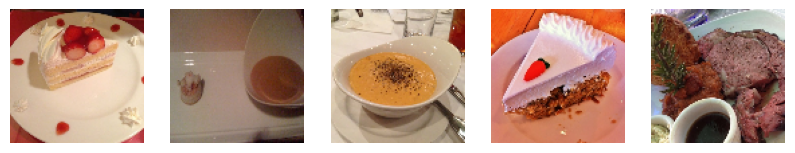

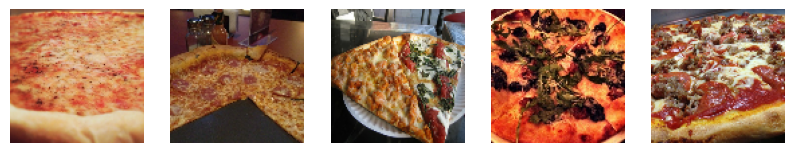

In [9]:
visualiza_imagenes_random()

## Modelo Red Pre Entrenada (Feature Extraction)

Para usar una red preentrenada haciendo el **Feature Extraction**, tendremos que coger el modelo de la red preentrenada que queramos usar, y quitarle la parte final, ésto lo haremos cuando creemos el modelo base con la opción **include_top=False**. De esta manera tendremos todas las capas previas que han sido entrenadas con millones de imágenes, y que no hará falta entrenar, pero nosotros le añadiremos la parte final para que aprenda a categorizar las imágenes de nuestro dataset.

En este modelo vamos a tener:

- Modelo base **VGG16**
- Capa para **aplanar** la información
- Capa de **dropout** al 0.3
- Capa **dénsamente conectada** de 256 neuronas y activación relu
- Capa **dénsamente conectada** de 64 neuronas y activación relu
- Capa de **salida de** 1 neurona y activación **sigmoid** que nos da la clasificación binaria

### Creamos el modelo

In [10]:
# Función para la creación del modelo 3
def crea_modelo_red_preentrenada():
    # Creamos el modelo
    # Capa de entrada formato 180x180 pixels y 3 canales de color RGB
    inputs = keras.Input(shape=(img_width, img_height, 3))
    
    # Dividimos entre 255 para "normalizar" el dato y dejarlo entre 0 7 1
    x = layers.Rescaling(1./255)(inputs)

    # Cargamos el modelo pre-entrenado de la red VGG16
    base_model = applications.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(100, 100, 3))  # No cargamos la parte de clasificación sólo las Feature Extraction
    
    # Bloqueamos para que no se entrenen estos parámetros
    base_model.trainable = False

    x = base_model(x)
    
    # Aplanamos los datos
    x = layers.Flatten()(x)

    # Ponemos la capa de dropout con 0.3
    x = layers.Dropout(0.3)(x)

    # Ponemos una capa densamente conectada
    x = layers.Dense(256, activation="relu")(x)
    
    # Ponemos una capa densamente conectada
    x = layers.Dense(64, activation="relu")(x)
    
    # La salida la hacemos de tipo softmax con 5 neuronas (números de clases diferentes)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # Construimos el modelo de la Red Neuronal Convolucional
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"])
    
    model.summary()
    return model


In [11]:
modelo_red_preentrenada = crea_modelo_red_preentrenada()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,911,105 (60.70 MB)

 Trainable params: 1,196,417 (4.56 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# Función que entrena el modelo que le pasemos
# Le asignamos el flujo de entrada de entranamiento y validación
# Ponemos 10 iteraciones
def entrena_modelo(modelo,epocas):
  # Ejecutamos el entrenamiento
  # guardando el histórico de la
  # función de pérdida y la métrica
  history = modelo.fit(
    train_ds,
    epochs = epocas,
    validation_data = val_ds )
  return history

In [14]:
history_red_preentrenada = entrena_modelo ( modelo_red_preentrenada, 10 )

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 338ms/step - accuracy: 0.6895 - loss: 0.5771 - val_accuracy: 0.7857 - val_loss: 0.4299
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.8529 - loss: 0.3519 - val_accuracy: 0.8469 - val_loss: 0.3113
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 607ms/step - accuracy: 0.8945 - loss: 0.2424 - val_accuracy: 0.8163 - val_loss: 0.4120
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 626ms/step - accuracy: 0.8834 - loss: 0.2444 - val_accuracy: 0.8010 - val_loss: 0.3889
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 673ms/step - accuracy: 0.9176 - loss: 0.2031 - val_accuracy: 0.8673 - val_loss: 0.3481
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 616ms/step - accuracy: 0.9396 - loss: 0.1560 - val_accuracy: 0.8316 - val_loss: 0.4375
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 694ms/step - accuracy: 0.9425 - loss: 0.1457 - val_accuracy: 0.8673 - val_loss: 0.3704
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 607ms/step - accuracy: 0.9528 - loss: 0.1186 - val_accu

In [17]:
# Mostramos las gráficas de histórico de entrenamiento
# de la función de pérdida y la métrica de entrenamiento y validación
def muestra_historico_entrenamiento(history, epocas):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epocas)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

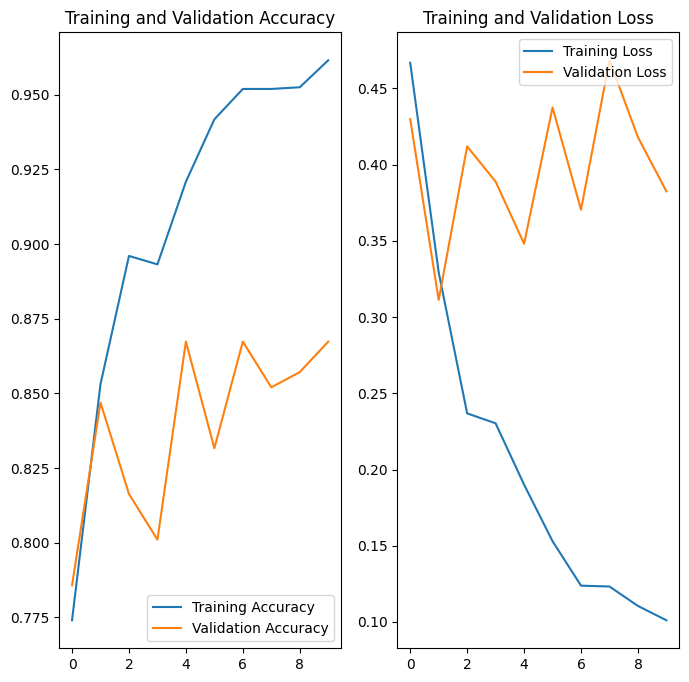

In [19]:
muestra_historico_entrenamiento(history_red_preentrenada, 10)

## Modelo Data Augmentation

El objetivo del **Data Augmentation** es aplicar transformaciones a las imágenes, de forma que siguen manteniendo su esencia (misma categoría) pero internamente son un conjunto de pixels diferentes. De esta manera podremos simular que tenemos muchos más datos de entrenamiento que originalmente. 

En este modelo vamos a tener:
- Capa **RandomFlip**
- Capa **RandomRotation**
- Capa **RandomZoom**
- Capa **convolución** con 32 filtros, tamaño 3x3 y activación relu
- Capa de **pooling** tipo maxpooling de tamaño 2x2
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación relu
- Capa de **pooling** tipo maxpooling de tamaño 2x2
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación relu
- Capa de **pooling** tipo maxpooling de tamaño 2x2
- Capa para **aplanar** la información
- Capa de **dropout** al 0.3
- Capa **dénsamente conectada** de 256 neuronas y activación relu
- Capa **dénsamente conectada** de 64 neuronas y activación relu
- Capa de **salida de** 1 neurona y activación **sigmoid** que nos da la clasificación binaria

### Creamos el modelo

In [20]:
def crea_modelo_data_augmentation():
    # Creamos el modelo
    # Capa de entrada formato 180x180 pixels y 3 canales de color RGB
    inputs = keras.Input(shape=(img_width, img_height, 3))
    
    # Dividimos entre 255 para "normalizar" el dato y dejarlo entre 0 7 1
    x = layers.Rescaling(1./255)(inputs)

    # Metemos las capas para hacer el Data Augmentation
    x = layers.RandomFlip("horizontal_and_vertical")(x)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.3)(x)

    # Añadimos capa de convolución con 32 filtros de tamaño 3 y activación relu
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    # Añadimos capa de pooling, tipo max y de tamaño 2
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    # Añadimos capa de pooling, tipo max y de tamaño 2
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    # Añadimos capa de pooling, tipo max y de tamaño 2
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    # Aplanamos los datos
    x = layers.Flatten()(x)

    # Ponemos la capa de dropout con 0.3
    x = layers.Dropout(0.3)(x)

    # Ponemos una capa densamente conectada
    x = layers.Dense(256, activation="relu")(x)
    
    # Ponemos una capa densamente conectada
    x = layers.Dense(64, activation="relu")(x)
    
    # La salida la hacemos de tipo softmax con 5 neuronas (números de clases diferentes)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    # Construimos el modelo de la Red Neuronal Convolucional
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"])
    
    model.summary()
    return model


In [21]:
modelo_data_augmentation = crea_modelo_data_augmentation()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,711,489 (6.53 MB)

 Trainable params: 1,711,489 (6.53 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamos el modelo

In [22]:
history_data_augmentation = entrena_modelo ( modelo_data_augmentation, 10 )

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5381 - loss: 0.6934 - val_accuracy: 0.5051 - val_loss: 0.6875
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6127 - loss: 0.6581 - val_accuracy: 0.6224 - val_loss: 0.6462
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6245 - loss: 0.6350 - val_accuracy: 0.6888 - val_loss: 0.5912
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7050 - loss: 0.5507 - val_accuracy: 0.6429 - val_loss: 0.6657
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7075 - loss: 0.5623 - val_accuracy: 0.7041 - val_loss: 0.5769
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7245 - loss: 0.5280 - val_accuracy: 0.7653 - val_loss: 0.5511
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7431 - loss: 0.5297 - val_accuracy: 0.6684 - val_loss: 0.6495
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7402 - loss: 0.5238 - val_accuracy: 0.7551 - v

### Mostramos el histórico del entrenamiento

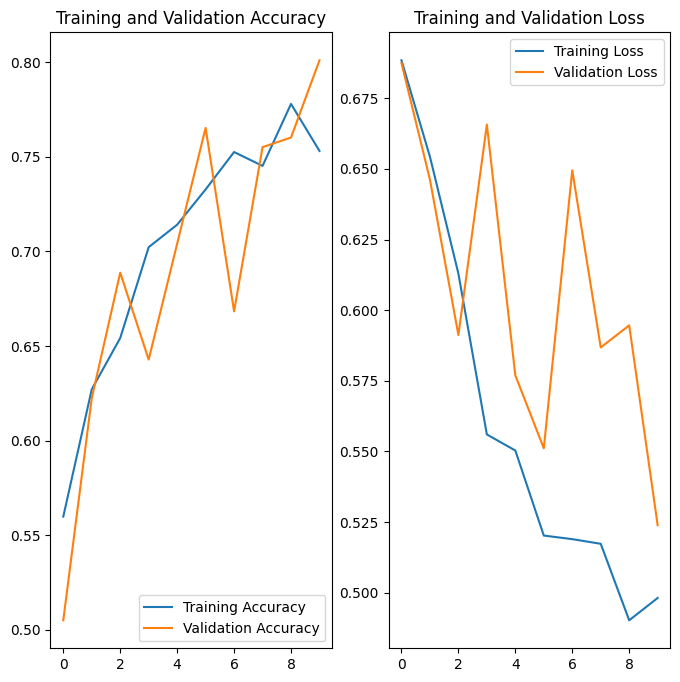

In [23]:
muestra_historico_entrenamiento(history_data_augmentation, 10)